# DuckDB + Parquet Data Exploration Template

In [29]:
from pathlib import Path
from tqdm import tqdm
import json
from IPython.display import display

import duckdb
import pandas as pd
import geopandas as gpd
import numpy as np

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from matplotlib import colors, ticker
from typing import Optional, Tuple
from matplotlib.cm import ScalarMappable
import folium
import matplotlib.dates as mdates

from src.gen_points_map import compute_step, make_equal_area_hex_grid
from src.geo_util import assign_intersection_id

# --- Configuration ---

In [30]:
BASE = Path("/Users/kyledorman/data/planet_coverage/ca_only/")  # <-- update this

# Example path patterns
f_pattern = "*/coastal_results/*/*/*/coastal_points.parquet"
all_files_pattern = str(BASE / f_pattern)

# Combined list used later when we search individual files
all_parquets = list(BASE.glob(f_pattern))

IDX = 1
hex_id = f"{IDX:06x}"  # unique 6‑digit hex, e.g. '0f1a2b'
d1, d2, d3 = hex_id[:2], hex_id[2:4], hex_id[4:6]
GRID_PATH = BASE / "dove" / "coastal_results" / d1 / d2 / d3
FILE = GRID_PATH / "coastal_points.parquet"

assert FILE.exists()

len(all_parquets)

56

In [4]:
display_crs = "EPSG:4326"
robinson_crs = "ESRI:54030"
sinus_crs = "ESRI:54008"

ca_ocean = gpd.read_file(BASE / "ca_ocean.geojson")
query_df = gpd.read_file(BASE / "ocean_grids.gpkg")
grids_df = gpd.read_file(BASE / "coastal_grids.gpkg").rename(columns={"cell_id": "grid_id"})
heuristics_df = pd.read_csv(BASE / "simulated_tidal_coverage_heuristics.csv").set_index("cell_id")

cell_size_m = compute_step(1.5)
_, hex_grid = make_equal_area_hex_grid(cell_size_m, robinson_crs)
hex_grid = hex_grid.rename(columns={"cell_id": "hex_id"}).to_crs(display_crs)

# Assign hex_id to query_df and grid_df
grids_df = assign_intersection_id(grids_df, hex_grid, "grid_id", "hex_id", sinus_crs)
query_df = assign_intersection_id(query_df, hex_grid, "cell_id", "hex_id", sinus_crs)

# Assign cell_id to grid_df
grids_df = assign_intersection_id(grids_df, query_df, "grid_id", "cell_id", sinus_crs)

# Add tidal information to grids_df and query_df
grids_df = grids_df.set_index("cell_id").join(heuristics_df, how='left').reset_index()
query_df = query_df.set_index("cell_id").join(heuristics_df, how='left').reset_index()

# Set plot crs
query_df = query_df.to_crs(display_crs)
grids_df = grids_df.to_crs(display_crs)

# Set indexes
query_df = query_df.set_index("cell_id")
grids_df = grids_df.set_index("grid_id")
hex_grid = hex_grid.set_index("hex_id")

# Filter grids to CA region
query_ca = query_df[query_df.geometry.intersects(ca_ocean.union_all())]
grids_ca = grids_df[grids_df.geometry.intersects(query_ca.union_all())]
hex_grid_ca = hex_grid[hex_grid.geometry.intersects(query_ca.union_all())]

len(grids_ca), len(query_ca), len(hex_grid_ca)

/opt/homebrew/Caskroom/miniconda/base/envs/planet_coverage/lib/python3.11/site-packages/shapely/set_operations.py:131: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/opt/homebrew/Caskroom/miniconda/base/envs/planet_coverage/lib/python3.11/site-packages/shapely/constructive.py:532: RuntimeWarning: invalid value encountered in make_valid
  return lib.make_valid(geometry, **kwargs)
/opt/homebrew/Caskroom/miniconda/base/envs/planet_coverage/lib/python3.11/site-packages/shapely/set_operations.py:131: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/opt/homebrew/Caskroom/miniconda/base/envs/planet_coverage/lib/python3.11/site-packages/shapely/constructive.py:532: RuntimeWarning: invalid value encountered in make_valid
  return lib.make_valid(geometry, **kwargs)
/opt/homebrew/Caskroom/miniconda/base/envs/planet_coverage/lib/python3.11/site-packages/shapely/set_operations.py:131: RuntimeWa

(4048, 115, 75)

In [5]:
centroid = ca_ocean.geometry[0].centroid
base_map = folium.Map(location=[centroid.y, centroid.x], zoom_start=5, width=1000, height=800)

for idx, geo in enumerate(ca_ocean.geometry):
    folium.GeoJson(
        geo,
        name=str(idx),
        style_function=lambda feature: {
            "color": "red",
            "weight": 4,
        }
    ).add_to(base_map)

for gid, row in query_ca.iterrows():
    folium.GeoJson(
        row.geometry,
        popup=str(gid),
        style_function=lambda feature: {
            "color": "blue",
            "weight": 2,
        }
    ).add_to(base_map)

for gid, row in grids_ca.iterrows():
    folium.GeoJson(
        row.geometry,
        popup=str(gid),
        style_function=lambda feature: {
            "color": "green",
            "weight": 1,
        }
    ).add_to(base_map)

for gid, row in hex_grid_ca.iterrows():
    folium.GeoJson(
        row.geometry,
        popup=str(gid),
        style_function=lambda feature: {
            "color": "yellow",
            "weight": 1,
        }
    ).add_to(base_map)

# Display the map
base_map

In [6]:
# --- Connect to DuckDB ---
con = duckdb.connect()

In [7]:
# Register a view for all files
con.execute(
    f"""
    CREATE OR REPLACE VIEW samples_all AS
    SELECT * FROM read_parquet('{all_files_pattern}');
"""
)

In [8]:
# Register a view for a single file for faster iteration
con.execute(f"""
    CREATE OR REPLACE VIEW samples_one AS
    SELECT * FROM '{FILE}'
""")

In [9]:
# --- Schema Inspection ---
print("Schema of samples_one:")
df = con.execute("DESCRIBE samples_one").fetchdf()
print(df)

Schema of samples_one:
                 column_name column_type null   key default extra
0                    grid_id    UINTEGER  YES  None    None  None
1                         id     VARCHAR  YES  None    None  None
2                   acquired   TIMESTAMP  YES  None    None  None
3                  item_type     VARCHAR  YES  None    None  None
4               satellite_id     VARCHAR  YES  None    None  None
5                 instrument     VARCHAR  YES  None    None  None
6              query_cell_id    UINTEGER  YES  None    None  None
7              has_8_channel     BOOLEAN  YES  None    None  None
8               has_sr_asset     BOOLEAN  YES  None    None  None
9              clear_percent       FLOAT  YES  None    None  None
10          quality_category     VARCHAR  YES  None    None  None
11            ground_control     BOOLEAN  YES  None    None  None
12          publishing_stage     VARCHAR  YES  None    None  None
13         satellite_azimuth       FLOAT  YES  None  

In [10]:
# --- NULL Check ---
print("Checking for NULL values:")
df_nulls = con.execute("""
    SELECT
        SUM(CASE WHEN id IS NULL THEN 1 ELSE 0 END) AS null_id,
        SUM(CASE WHEN acquired IS NULL THEN 1 ELSE 0 END) AS null_acquired,
        SUM(CASE WHEN item_type IS NULL THEN 1 ELSE 0 END) AS null_item_type,
        SUM(CASE WHEN satellite_id IS NULL THEN 1 ELSE 0 END) AS null_satellite_id,
        SUM(CASE WHEN instrument IS NULL THEN 1 ELSE 0 END) AS null_instrument,

        SUM(CASE WHEN cell_id IS NULL THEN 1 ELSE 0 END) AS null_cell_id,
        SUM(CASE WHEN grid_id IS NULL THEN 1 ELSE 0 END) AS null_grid_id,
        
        SUM(CASE WHEN has_8_channel IS NULL THEN 1 ELSE 0 END) AS null_has_8_channel,
        SUM(CASE WHEN has_sr_asset IS NULL THEN 1 ELSE 0 END) AS null_has_sr_asset,
        SUM(CASE WHEN clear_percent IS NULL THEN 1 ELSE 0 END) AS null_clear_percent,
        SUM(CASE WHEN quality_category IS NULL THEN 1 ELSE 0 END) AS null_quality_category,
        SUM(CASE WHEN ground_control IS NULL THEN 1 ELSE 0 END) AS null_ground_control,
        SUM(CASE WHEN publishing_stage IS NULL THEN 1 ELSE 0 END) AS null_publishing_stage,
        
        SUM(CASE WHEN satellite_azimuth IS NULL THEN 1 ELSE 0 END) AS null_satellite_azimuth,
        SUM(CASE WHEN sun_azimuth IS NULL THEN 1 ELSE 0 END) AS null_sun_azimuth,
        SUM(CASE WHEN sun_elevation IS NULL THEN 1 ELSE 0 END) AS null_sun_elevation,
        SUM(CASE WHEN view_angle IS NULL THEN 1 ELSE 0 END) AS null_view_angle,
        
        SUM(CASE WHEN tide_height IS NULL THEN 1 ELSE 0 END) AS null_tide_height,
        SUM(CASE WHEN has_tide_data IS NULL THEN 1 ELSE 0 END) AS null_has_tide_data,
        SUM(CASE WHEN tide_height_bin IS NULL THEN 1 ELSE 0 END) AS null_tide_height_bin,
        SUM(CASE WHEN coverage_pct IS NULL THEN 1 ELSE 0 END) AS null_coverage_pct,
        SUM(CASE WHEN intersects_grid_centroid IS NULL THEN 1 ELSE 0 END) AS null_intersects_grid_centroid,

        SUM(CASE WHEN geometry_wkb IS NULL THEN 1 ELSE 0 END) AS null_geometry_wkb,
    FROM samples_one
""").fetchdf()
df_nulls

Checking for NULL values:


null_id  null_acquired  null_item_type  null_satellite_id  null_instrument  \
0      0.0            0.0             0.0                0.0              0.0   

   null_cell_id  null_grid_id  null_has_8_channel  null_has_sr_asset  \
0           0.0           0.0                 0.0                0.0   

   null_clear_percent  ...  null_sun_azimuth  null_sun_elevation  \
0                 0.0  ...               0.0                 0.0   

   null_view_angle  null_tide_height  null_has_tide_data  \
0              0.0               0.0                 0.0   

   null_tide_height_bin  null_coverage_pct  null_intersects_grid_centroid  \
0                   0.0                0.0                            0.0   

   null_coverage_pct_1  null_geometry_wkb  
0                  0.0                0.0  

[1 rows x 24 columns]

In [11]:
cols = ['item_type', 'instrument', 'has_8_channel ', 'has_sr_asset', 'quality_category', 'ground_control', 'publishing_stage']
for col in cols:
    df = con.execute(f"SELECT DISTINCT {col} from samples_all").fetchdf()
    display(df.head())

item_type
0        PSScene
1  SkySatCollect

instrument
0     SkySat
1     PS2.SD
2     PSB.SD
3        PS2

has_8_channel
0          False
1           True

has_sr_asset
0         False
1          True

quality_category
0             test
1         standard

ground_control
0           False
1            True

publishing_stage
0        finalized
1          preview
2         standard

In [12]:
# --- Preview Data ---
df_preview = con.execute("SELECT * FROM samples_one LIMIT 5").fetchdf()
df_preview

grid_id                    id                   acquired item_type  \
0  12487145  20161128_173419_0e14 2016-11-28 17:34:19.847646   PSScene   
1  12487145  20161128_173418_0e14 2016-11-28 17:34:18.715524   PSScene   
2  12487145  20161123_173326_0e14 2016-11-23 17:33:26.995010   PSScene   
3  12487145  20161123_173328_0e14 2016-11-23 17:33:28.127132   PSScene   
4  12487145  20161114_154106_0c41 2016-11-14 15:41:06.679484   PSScene   

  satellite_id instrument  query_cell_id  has_8_channel  has_sr_asset  \
0         0e14        PS2          30965          False          True   
1         0e14        PS2          30965          False          True   
2         0e14        PS2          30965          False          True   
3         0e14        PS2          30965          False          True   
4         0c41        PS2          30965          False         False   

   clear_percent  ... sun_elevation  view_angle cell_id  tide_height  \
0          100.0  ...          30.6         0.6   30660     0.170884   
1           99.0  ...          30.5         0.6   30660     0.170609   
2           99.0  ...          31.5         0.7   30660     1.304998   
3          100.0  ...          31.6         0.7   30660     1.305024   
4          100.0  ...          17.1         1.6   30660    -2.122537   

   has_tide_data  tide_height_bin  is_mid_tide  coverage_pct  \
0           True                5         True      0.013258   
1           True                5         True      0.001619   
2           True                8        False      0.180896   
3           True                8        False      0.923614   
4           True                0        False      0.311027   

   intersects_grid_centroid                                       geometry_wkb  
0                     False  [1, 3, 0, 0, 0, 1, 0, 0, 0, 4, 0, 0, 0, 18, 11...  
1                     False  [1, 3, 0, 0, 0, 1, 0, 0, 0, 4, 0, 0, 0, 145, 2...  
2                     False  [1, 3, 0, 0, 0, 1, 0, 0, 0, 5, 0, 0, 0, 18, 11...  
3                      True  [1, 3, 0, 0, 0, 1, 0, 0, 0, 6, 0, 0, 0, 109, 1...  
4                     False  [1, 3, 0, 0, 0, 1, 0, 0, 0, 5, 0, 0, 0, 18, 11...  

[5 rows x 25 columns]

In [13]:
# --- Filter By Time ---
df_2024 = con.execute("""
    SELECT *
    FROM samples_one
    WHERE acquired >= '2024-01-01' AND acquired < '2025-01-01'
    LIMIT 100
""").fetchdf()
df_2024.head(5)

grid_id                       id                   acquired item_type  \
0  12487145  20241130_183636_77_24f9 2024-11-30 18:36:36.774663   PSScene   
1  12487145  20241129_175012_09_24c1 2024-11-29 17:50:12.095505   PSScene   
2  12487145  20241128_183428_80_250d 2024-11-28 18:34:28.802856   PSScene   
3  12487145  20241128_183641_68_24ae 2024-11-28 18:36:41.681585   PSScene   
4  12487145  20241128_183643_98_24ae 2024-11-28 18:36:43.982345   PSScene   

  satellite_id instrument  query_cell_id  has_8_channel  has_sr_asset  \
0         24f9     PSB.SD          30965           True          True   
1         24c1     PSB.SD          30965           True          True   
2         250d     PSB.SD          30965           True          True   
3         24ae     PSB.SD          30965           True          True   
4         24ae     PSB.SD          30965           True          True   

   clear_percent  ... sun_elevation  view_angle cell_id  tide_height  \
0           98.0  ...     35.299999         4.9   30660     0.892663   
1            0.0  ...     32.000000         1.8   30660     0.702264   
2           96.0  ...     35.900002         4.9   30660     1.253376   
3           87.0  ...     35.700001         2.7   30660     1.263149   
4          100.0  ...     35.900002         2.7   30660     1.263314   

   has_tide_data  tide_height_bin  is_mid_tide  coverage_pct  \
0           True                7        False      0.226554   
1           True                6        False      1.000000   
2           True                8        False      1.000000   
3           True                8        False      0.000610   
4           True                8        False      0.116146   

   intersects_grid_centroid                                       geometry_wkb  
0                     False  [1, 3, 0, 0, 0, 1, 0, 0, 0, 4, 0, 0, 0, 18, 11...  
1                      True  [1, 3, 0, 0, 0, 1, 0, 0, 0, 5, 0, 0, 0, 67, 19...  
2                      True  [1, 3, 0, 0, 0, 1, 0, 0, 0, 5, 0, 0, 0, 67, 19...  
3                     False  [1, 3, 0, 0, 0, 1, 0, 0, 0, 4, 0, 0, 0, 39, 24...  
4                     False  [1, 3, 0, 0, 0, 1, 0, 0, 0, 4, 0, 0, 0, 18, 11...  

[5 rows x 25 columns]

In [14]:
def plot_gdf_column(
    gdf: gpd.GeoDataFrame,
    column: str,
    *,
    projection: ccrs.CRS = ccrs.Robinson(),
    cmap: str = "viridis",
    vmin: Optional[float] = None,
    vmax: Optional[float] = None,
    scale: str = "linear",               # "linear"  or  "log"
    figsize: Tuple[int, int] = (12, 6),
    edgecolor: str = "black",
    linewidth: float = 0.15,
    show_coastlines: bool = False,
    show_grid: bool = False,
    title: Optional[str] = None,
    save_path: str | None = None,
    pad_fraction: float = 0.05,          # extra space around data bounds
) -> None:
    """
    Plot a numeric column from a GeoDataFrame on a Cartopy map, zooming to the
    area where data exist.

    `pad_fraction` adds a percentage of the data extent as padding so the data
    don’t touch the frame edge.
    """
    # ------------------------------------------------------------------
    # Basic checks
    # ------------------------------------------------------------------
    if gdf.crs is None or gdf.crs.to_epsg() != 4326:
        raise ValueError("GeoDataFrame must be in EPSG:4326 (lon/lat degrees)")
    if column not in gdf.columns:
        raise KeyError(f"{column!r} not found in GeoDataFrame")

    # ------------------------------------------------------------------
    # Detect datetime columns and transform
    # ------------------------------------------------------------------
    is_datetime = np.issubdtype(gdf[column].dtype, np.datetime64)
    if is_datetime:
        numeric_vals = mdates.date2num(gdf[column].values)     # float array
    else:
        numeric_vals = gdf[column].astype(float).values

    gdf = gdf.copy()
    gdf["_tmp"] = numeric_vals        # temp numeric column
    column = "_tmp"

    data = gdf[column].astype(float)

    # ------------------------------------------------------------------
    # Colour range & normalisation
    # ------------------------------------------------------------------
    if vmin is None:
        vmin = data[data > 0].min() if scale == "log" else data.min()
    if vmax is None:
        vmax = data.max()

    if is_datetime:
        norm = colors.Normalize(vmin=numeric_vals.min(), vmax=numeric_vals.max())
    
        # human-readable ticks every N months
        def _fmt(x, _):
            return mdates.num2date(x).strftime("%Y-%m")
        formatter = ticker.FuncFormatter(_fmt)
        locator = ticker.MaxNLocator(nbins=6)       # or mdates.MonthLocator()
    else:
        # keep your linear / log branch as-is
        if scale == "log":
            if (data <= 0).any():
                raise ValueError("Log scale selected but column contains non-positive values.")
            norm = colors.LogNorm(vmin=vmin, vmax=vmax)
            formatter = ticker.FuncFormatter(lambda y, _: f"{y:g}")
            locator = ticker.LogLocator(base=10, numticks=10)
        else:
            norm = colors.Normalize(vmin=vmin, vmax=vmax)
            formatter = ticker.ScalarFormatter()
            locator = ticker.MaxNLocator(nbins=6)

    cmap = plt.get_cmap(cmap)

    # ------------------------------------------------------------------
    # Prepare figure / axis
    # ------------------------------------------------------------------
    fig = plt.figure(figsize=figsize)
    ax = plt.axes(projection=projection)

    # Compute extent from data bounds (EPSG:4326) and add a small margin
    xmin, ymin, xmax, ymax = gdf.total_bounds
    dx, dy = xmax - xmin, ymax - ymin
    if dx == 0 or dy == 0:        # degenerate case (single point / line)
        dx = dy = max(dx, dy) or 1.0  # give it 1° span to avoid zero-width
    pad_x = dx * pad_fraction
    pad_y = dy * pad_fraction
    ax.set_extent([xmin - pad_x, xmax + pad_x, ymin - pad_y, ymax + pad_y],
                  crs=ccrs.PlateCarree())

    # ------------------------------------------------------------------
    # Plot data
    # ------------------------------------------------------------------
    gdf.plot(
        column=column,
        cmap=cmap,
        norm=norm,
        ax=ax,
        transform=ccrs.PlateCarree(),
        edgecolor=edgecolor,
        linewidth=linewidth,
    )

    if show_coastlines:
        ax.coastlines(resolution="110m", linewidth=0.3)
    if show_grid:
        ax.gridlines(draw_labels=False, linewidth=0.2)

    # Colour bar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax, orientation="vertical",
                        shrink=0.65, pad=0.02, format=formatter)
    cbar.locator = locator
    cbar.update_ticks()
    cbar.set_label(column)

    if title:
        ax.set_title(title, pad=12)

    plt.tight_layout()
    if save_path is not None:
        plt.savefig(save_path)
    plt.show()

In [22]:
df_dates = con.execute("""
    SELECT 
        grid_id, 
        cell_id,
        MIN(acquired) as first_sample,
        MAX(acquired) as last_sample
    FROM samples_all
    WHERE item_type = 'PSScene'
    GROUP BY grid_id, cell_id
""").fetchdf().set_index("grid_id")

print(df_dates.first_sample.min(), df_dates.first_sample.max())
print(df_dates.last_sample.min(), df_dates.last_sample.max())
print(len(df_dates), len(grids_df))
print(len(df_dates.cell_id.unique()), len(query_df))

2015-12-13 22:48:22.254675 2019-03-19 18:56:35.013978
2024-04-18 19:18:30.713600 2025-05-07 19:39:55.930370
4048 949044
36 31823


In [ ]:
# --- Load Geo Points and Join ---

# Sample count per grid cell
df_counts = con.execute("""
    SELECT grid_id, COUNT(*) as sample_count
    FROM samples_all
    WHERE item_type = 'PSScene'
    GROUP BY grid_id
""").fetchdf().set_index("grid_id")

geo_plot = grids_ca.join(df_counts, how="left").fillna({"sample_count": 0})

plot_gdf_column(geo_plot, "sample_count", title="Sample Count PSScene", show_coastlines=True)

In [ ]:
# --- Load Geo Points and Join ---

# Sample count per grid cell
df_counts = con.execute("""
    SELECT grid_id, COUNT(*) as sample_count
    FROM samples_all
    WHERE item_type = 'PSScene'
    GROUP BY grid_id
""").fetchdf().set_index("grid_id")

geo_plot = grids_ca.join(df_counts, how="left").fillna({"sample_count": 0})

df = pd.DataFrame(geo_plot.groupby("hex_id")["sample_count"].sum())
df = df[df.index >= 0]
df = df.join(hex_grid_ca[["geometry"]])
gdf = gpd.GeoDataFrame(df, geometry="geometry")

plot_gdf_column(gdf, "sample_count", title="Sample Count PSScene Hex", show_coastlines=True)

In [ ]:
# --- Load Geo Points and Join ---

# Sample count per grid cell
df_counts = con.execute("""
    SELECT grid_id, COUNT(*) as sample_count
    FROM samples_all
    WHERE item_type = 'PSScene'
    AND coverage_pct > 0.5
    AND publishing_stage = 'finalized'
    AND quality_category = 'standard'
    AND has_sr_asset
    AND ground_control
    GROUP BY grid_id
""").fetchdf().set_index("grid_id")

geo_plot = grids_ca.join(df_counts, how="left").fillna({"sample_count": 0})

df = pd.DataFrame(geo_plot.groupby("hex_id")["sample_count"].sum())
df = df[df.index >= 0]
df = df.join(hex_grid_ca[["geometry"]])
gdf = gpd.GeoDataFrame(df, geometry="geometry")

plot_gdf_column(gdf, "sample_count", title="High Quality Sample Count", show_coastlines=True)

In [ ]:
# --- Load Geo Points and Join ---

df = con.execute(
    """
    SELECT grid_id, SUM(coverage_pct > 0.5)::DOUBLE AS coverage_count,  COUNT(*) as sample_count
    FROM samples_all
    WHERE item_type = 'PSScene'
    GROUP BY grid_id
"""
).fetchdf().set_index("grid_id")

geo_coverage = grids_ca.join(df, how="left").fillna({"sample_count": 1.0, "coverage_count": 0.0})
geo_coverage["sample_pct"] = geo_coverage.coverage_count / geo_coverage.sample_count 

plot_gdf_column(geo_coverage, "sample_pct", title="% Greater than 50% coverage", show_coastlines=True)

agg = (
    geo_coverage.groupby('hex_id', as_index=False, sort=False)[['coverage_count', 'sample_count']]
      .sum()                                # ← sums within each hex
      .assign(
          coverage_pct=lambda d: d['coverage_count'] / d['sample_count']  # or * 100 for %
      )
)
agg = agg.set_index("hex_id")[agg.index >= 0]
agg = agg.join(hex_grid_ca[["geometry"]])
gdf = gpd.GeoDataFrame(agg, geometry="geometry")

plot_gdf_column(gdf, "coverage_pct", title="% Greater than 50% coverage", show_coastlines=True)

In [ ]:
# --- Load Geo Points and Join ---

df_pct = con.execute(
    """
    SELECT grid_id,
           SUM(intersects_grid_centroid)::DOUBLE as coverage_count,
           COUNT(*) AS sample_count
    FROM samples_all
    WHERE item_type = 'PSScene'
    GROUP BY grid_id
"""
).fetchdf().set_index("grid_id")

geo_coverage = grids_ca.join(df_pct, how="left").fillna({"sample_count": 1.0, "coverage_count": 0.0})
geo_coverage["sample_pct"] = geo_coverage.coverage_count / geo_coverage.sample_count 

plot_gdf_column(geo_coverage, "sample_pct", title="% Intersects Grid Center", show_coastlines=True)

agg = (
    geo_coverage.groupby('hex_id', as_index=False, sort=False)[['coverage_count', 'sample_count']]
      .sum()                                # ← sums within each hex
      .assign(
          coverage_pct=lambda d: d['coverage_count'] / d['sample_count']  # or * 100 for %
      )
)
agg = agg.set_index("hex_id")[agg.index >= 0]
agg = agg.join(hex_grid_ca[["geometry"]])
gdf = gpd.GeoDataFrame(agg, geometry="geometry")

plot_gdf_column(gdf, "coverage_pct", title="% Intersects Grid Center", show_coastlines=True)

In [ ]:
# --- Load Geo Points and Join ---

df_pct = con.execute(
    """
    SELECT grid_id,
           SUM(intersects_grid_centroid)::DOUBLE  / SUM(coverage_pct > 0.5)::DOUBLE AS frac_coverage
    FROM samples_all
    WHERE item_type = 'PSScene'
    GROUP BY grid_id
"""
).fetchdf().set_index("grid_id")

geo_pct = grids_ca.join(df_pct, how="left").fillna({"frac_coverage": 0.0})

plot_gdf_column(geo_pct, "frac_coverage", title="Ration grid center vs 50% coverage", show_coastlines=True)

In [ ]:
# --- Load Geo Points and Join ---

df_pct = con.execute(
    """
    SELECT grid_id,
           SUM(intersects_grid_centroid)::DOUBLE  / SUM(coverage_pct > 0.75)::DOUBLE AS frac_coverage
    FROM samples_all
    WHERE item_type = 'PSScene'
    GROUP BY grid_id
"""
).fetchdf().set_index("grid_id")

geo_pct = grids_ca.join(df_pct, how="left").fillna({"frac_coverage": 0.0})

plot_gdf_column(geo_pct, "frac_coverage", title="Ration grid center vs 75% coverage", show_coastlines=True)

In [ ]:
df_cov = con.execute("""
    SELECT
        grid_id,
        COUNT(*)                                                  AS sample_count,
        SUM(CASE WHEN coverage_pct > 0.5 THEN 1 ELSE 0 END)      AS coverage_count,
    FROM samples_all
    WHERE item_type        = 'PSScene'
      AND publishing_stage = 'finalized'
      AND quality_category = 'standard'
      AND has_sr_asset
      AND ground_control
    GROUP BY grid_id
""").fetchdf().set_index("grid_id")

# join with your coastal grid GeoDataFrame
geo_coverage = grids_ca.join(df_cov, how="left").fillna({"sample_count": 1.0, "coverage_count": 0.0})
geo_coverage["sample_pct"] = geo_coverage.coverage_count / geo_coverage.sample_count 

plot_gdf_column(geo_coverage, "sample_pct", title="% of high quality captures with >50 % area", show_coastlines=True)

agg = (
    geo_coverage.groupby('hex_id', as_index=False, sort=False)[['coverage_count', 'sample_count']]
      .sum()                                # ← sums within each hex
      .assign(
          coverage_pct=lambda d: d['coverage_count'] / d['sample_count']  # or * 100 for %
      )
)
agg = agg.set_index("hex_id")[agg.index >= 0]
agg = agg.join(hex_grid_ca[["geometry"]])
gdf = gpd.GeoDataFrame(agg, geometry="geometry")

plot_gdf_column(gdf, "coverage_pct", title="% of high quality captures with >50 % area", show_coastlines=True)

In [ ]:
# ---- Histogram Per Day Counts (w/Publish Stage) ---- #

# 1. Pull per-day counts broken out by stage
df_stage = con.execute("""
    SELECT
        date_trunc('day', acquired) AS day,
        publishing_stage,
        COUNT(DISTINCT id) AS cnt
    FROM samples_all
    WHERE item_type = 'PSScene'
    GROUP BY day, publishing_stage
    ORDER BY day
""").fetchdf()

# 2. Normalize day column and pivot so each stage is its own column
df_stage['day'] = pd.to_datetime(df_stage['day']).dt.date
df_pivot = (
    df_stage
    .pivot(index='day', columns='publishing_stage', values='cnt')
    .fillna(0)
)

# 3. Ensure a consistent stack order
stages = ['preview', 'finalized', 'standard']
df_pivot = df_pivot.reindex(columns=stages, fill_value=0)

# 4. Plot stacked bars
fig, ax = plt.subplots(figsize=(10, 4))
bottom = np.zeros(len(df_pivot))

for stage in stages:
    ax.bar(
        df_pivot.index.astype(str),
        df_pivot[stage],
        bottom=bottom,
        label=stage
    )
    bottom += df_pivot[stage].values

ax.set_xticklabels(df_pivot.index.astype(str), rotation=45, ha='right')
ax.set_title("Sample Count per Day by Publishing Stage")
ax.set_xlabel("Day")
ax.set_ylabel("Sample Count")
ax.legend(title="Publishing Stage")
fig.tight_layout()
plt.show()

In [24]:
def compute_minmax(column: str) -> pd.DataFrame:
    sql = f"""
        SELECT
        MIN({column}) AS minv,
        MAX({column}) AS maxv
        FROM samples_all
        WHERE item_type = 'PSScene'
    """
    return con.execute(sql).fetchdf()

def compute_histogram(column: str, nbins: int = 30) -> pd.DataFrame:
    """
    Runs DuckDB's histogram() table function on `column` in samples_all (filtered to PSScene)
    and returns a DataFrame with columns: bin_upper, frequency.
    """
    sql = f"""
        WITH bounds AS (
          SELECT
            MIN({column}) AS mn,
            MAX({column}) AS mx
          FROM samples_all
          WHERE item_type = 'PSScene'
        )
        SELECT
          -- histogram() returns a MAP<upper_boundary, count>
          histogram(
            {column},
            equi_width_bins(bounds.mn::DOUBLE, bounds.mx::DOUBLE, {nbins}::BIGINT, True)
          ) AS hist_map
        FROM samples_all
        CROSS JOIN bounds
        WHERE item_type = 'PSScene';
    """
    hist_map = con.execute(sql).fetchdf().iloc[0]["hist_map"]

    
    # Unpack into a two-column DataFrame
    df = pd.DataFrame({
        'bin_upper': list(hist_map.keys()),
        'count':     list(hist_map.values())
    })
    df = df.sort_values('bin_upper').reset_index(drop=True)
    uppers = df['bin_upper'].tolist()
    bin_size = uppers[1] - uppers[0]
    # Compute lower edge from previous upper
    lowest = uppers[0] - bin_size
    lowers = [lowest] + uppers[:-1]
    df["bin_lower"] = pd.Series(lowers)
    df["centers"] = (df["bin_lower"] + df['bin_upper']) / 2
    df["widths"]  = df['bin_upper'] - df["bin_lower"]
    return df

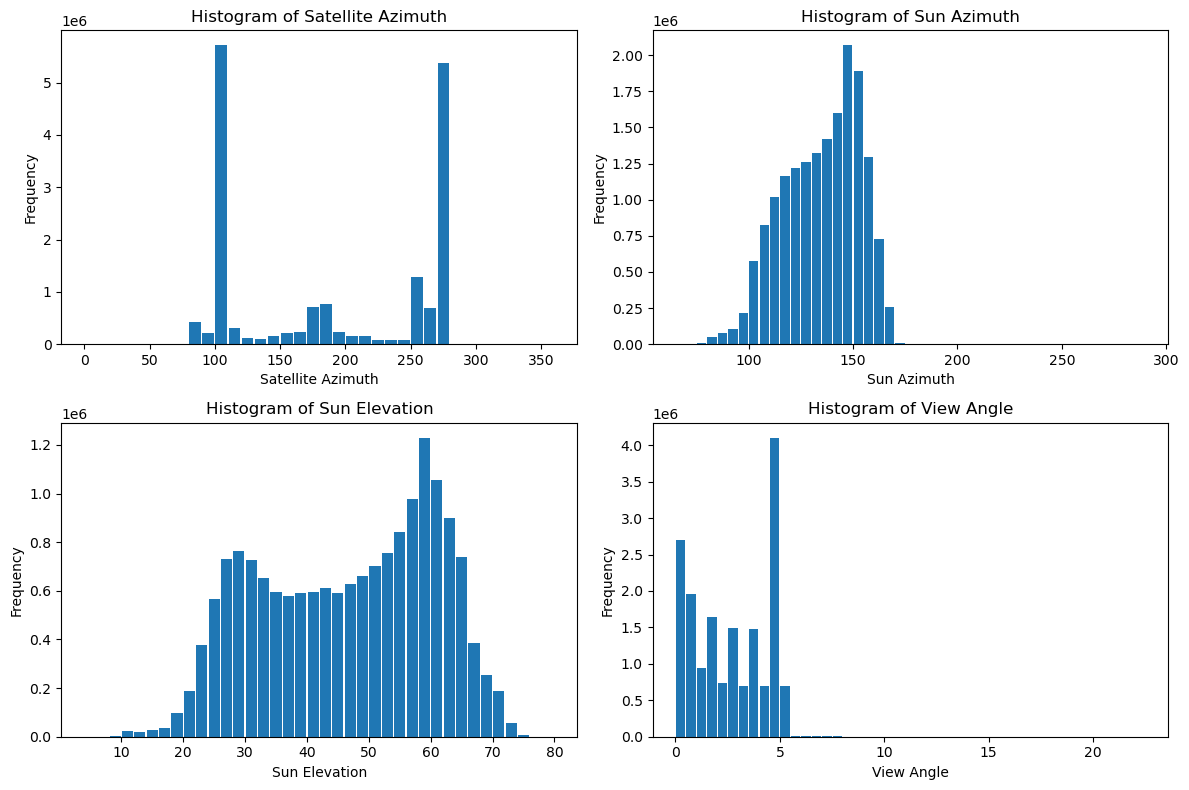

In [25]:
# Set up a 2×2 grid of histograms
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()


# 2. Plotting all four angle columns
for ax, col in zip(axes, ["satellite_azimuth", "sun_azimuth", "sun_elevation", "view_angle"]):
    df_hist = compute_histogram(col, nbins=30)

    ax.bar(df_hist["centers"], df_hist['count'], width=df_hist["widths"] * 0.9)
    ax.set_title(f"Histogram of {col.replace('_',' ').title()}")
    ax.set_xlabel(col.replace('_',' ').title())
    ax.set_ylabel("Frequency")
    
fig.tight_layout()
plt.show()

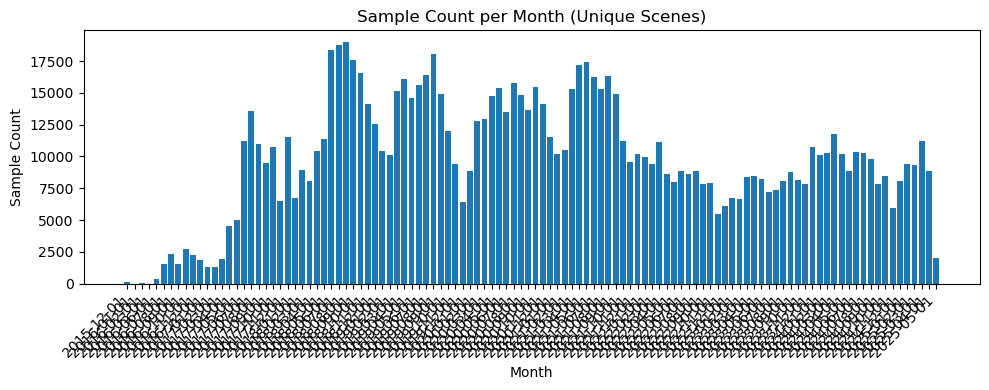

In [26]:
# --- Histogram of Sample Count per Month ---
df_monthly = con.execute("""
    SELECT date_trunc('month', acquired) AS month, COUNT(DISTINCT id) AS sample_count
    FROM samples_all
    WHERE item_type = 'PSScene'
    GROUP BY month
    ORDER BY month
""").fetchdf()

# Plot histogram
plt.figure(figsize=(10,4))
plt.bar(df_monthly['month'].astype(str), df_monthly['sample_count'])
plt.xticks(rotation=45, ha='right')
plt.title("Sample Count per Month (Unique Scenes)")
plt.xlabel("Month")
plt.ylabel("Sample Count")
plt.tight_layout()
plt.show()

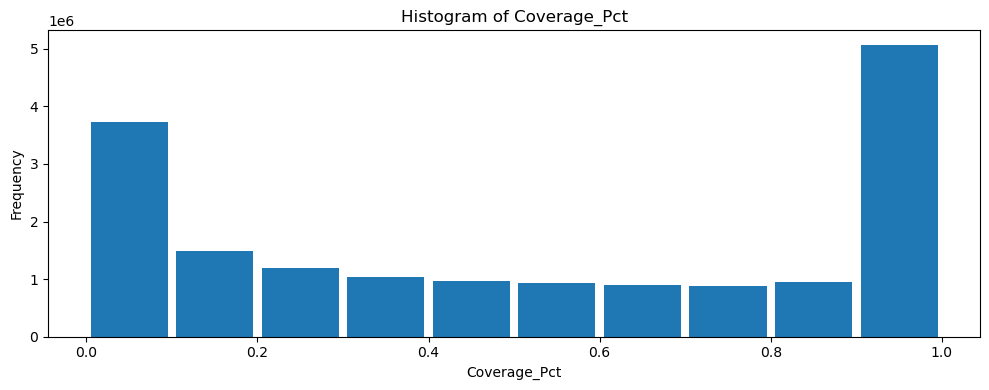

In [27]:
# --- Histogram of coverage_pct ---
fig, ax = plt.subplots(1, 1, figsize=(10, 4))

df_hist = compute_histogram("coverage_pct", nbins=10)

ax.bar(df_hist["centers"], df_hist['count'], width=df_hist["widths"] * 0.9)
ax.set_title(f"Histogram of {'coverage_pct'.title()}")
ax.set_xlabel("coverage_pct".title())
ax.set_ylabel("Frequency")
    
fig.tight_layout()
plt.show()

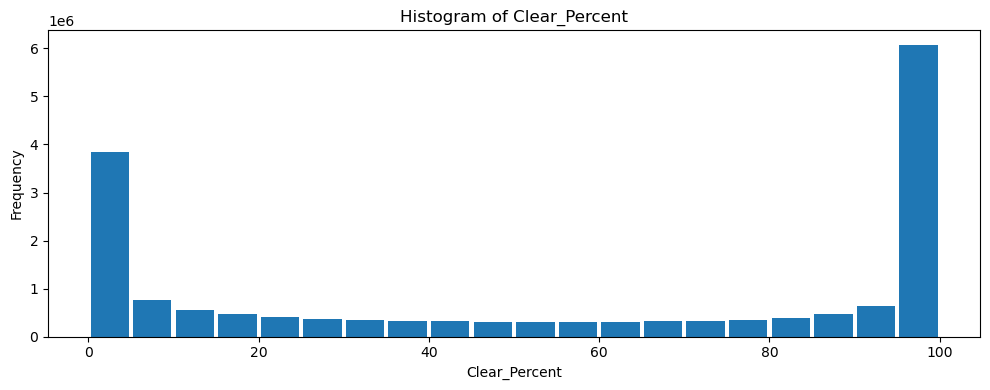

In [28]:
# --- Histogram of clear_percent ---
fig, ax = plt.subplots(1, 1, figsize=(10, 4))

df_hist = compute_histogram("clear_percent", nbins=30)

ax.bar(df_hist["centers"], df_hist['count'], width=df_hist["widths"] * 0.9)
ax.set_title(f"Histogram of {'clear_percent'.title()}")
ax.set_xlabel("clear_percent".title())
ax.set_ylabel("Frequency")
    
fig.tight_layout()
plt.show()

/opt/homebrew/Caskroom/miniconda/base/envs/planet_coverage/lib/python3.11/site-packages/shapely/constructive.py:180: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/opt/homebrew/Caskroom/miniconda/base/envs/planet_coverage/lib/python3.11/site-packages/shapely/predicates.py:778: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/opt/homebrew/Caskroom/miniconda/base/envs/planet_coverage/lib/python3.11/site-packages/shapely/constructive.py:180: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/opt/homebrew/Caskroom/miniconda/base/envs/planet_coverage/lib/python3.11/site-packages/shapely/predicates.py:778: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


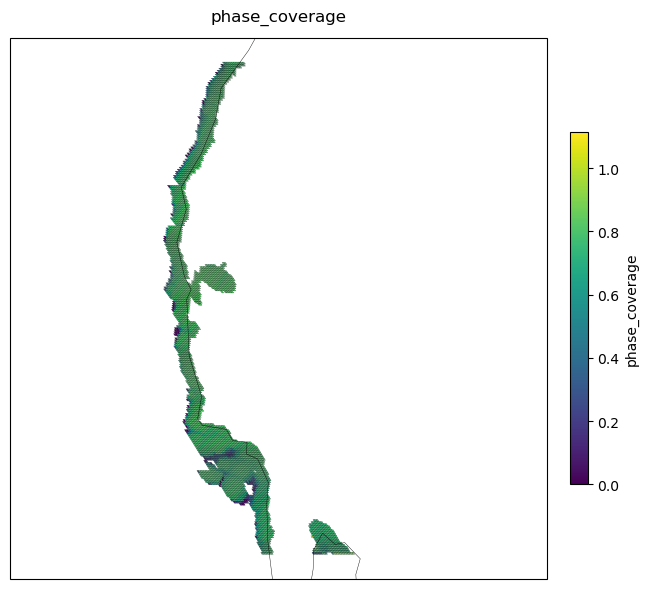

/opt/homebrew/Caskroom/miniconda/base/envs/planet_coverage/lib/python3.11/site-packages/shapely/constructive.py:180: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/opt/homebrew/Caskroom/miniconda/base/envs/planet_coverage/lib/python3.11/site-packages/shapely/predicates.py:778: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/opt/homebrew/Caskroom/miniconda/base/envs/planet_coverage/lib/python3.11/site-packages/shapely/constructive.py:180: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/opt/homebrew/Caskroom/miniconda/base/envs/planet_coverage/lib/python3.11/site-packages/shapely/predicates.py:778: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


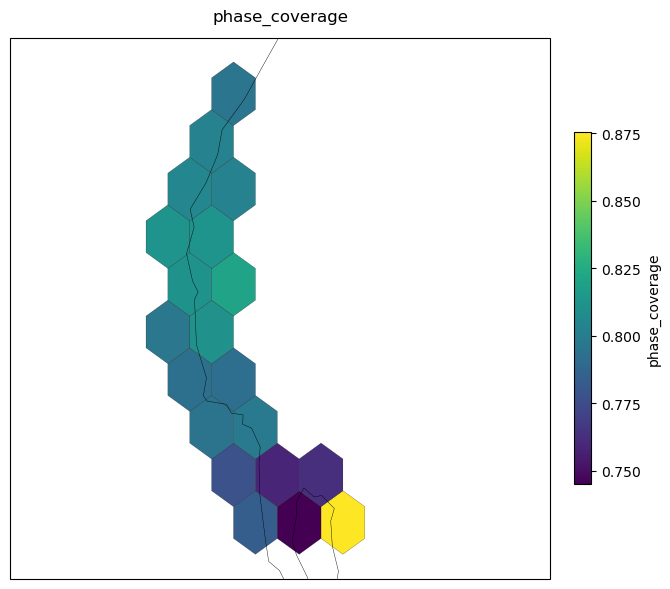

In [17]:
query = """
SELECT
    grid_id,
    MIN(tide_height) AS obs_min_tide_height,
    MAX(tide_height) AS obs_max_tide_height
FROM samples_all
WHERE
    acquired >= TIMESTAMP '2023-12-01'
    AND acquired <  TIMESTAMP '2025-01-01'
    AND item_type        = 'PSScene'
    AND publishing_stage = 'finalized'
    AND quality_category = 'standard'
    AND has_sr_asset
    AND ground_control
    AND has_tide_data
GROUP BY grid_id
ORDER BY grid_id;
"""

df = con.execute(query).fetchdf().set_index("grid_id")

geo_tide = grids_ca.join(df, how="left").dropna(subset=["obs_min_tide_height", "obs_max_tide_height", 'tide_range'])
geo_tide['obs_tide_range'] = geo_tide.obs_max_tide_height - geo_tide.obs_min_tide_height
geo_tide['phase_coverage'] = geo_tide['obs_tide_range'] / geo_tide['tide_range']
plot_gdf_column(geo_tide, "phase_coverage", title="phase_coverage", show_coastlines=True)

hex_tide = (
    geo_tide
      .groupby("hex_id")
      .agg(                 # keep one row per hex_id
          obs_min_tide_height=("obs_min_tide_height", "min"),   # lowest observed tide
          obs_max_tide_height=("obs_max_tide_height", "max"),   # highest observed tide
          tide_min=("tide_min", "min"),   # lowest tide
          tide_max=("tide_max", "max"),   # highest tide
      )
)
hex_tide['tide_range'] = hex_tide.tide_max - hex_tide.tide_min
hex_tide['obs_tide_range'] = hex_tide.obs_max_tide_height - hex_tide.obs_min_tide_height
hex_tide['phase_coverage'] = hex_tide.obs_tide_range / hex_tide.tide_range

hex_tide = hex_tide[hex_tide.index >= 0]
hex_tide = hex_tide.join(hex_grid_ca[["geometry"]])
gdf = gpd.GeoDataFrame(hex_tide, geometry="geometry")

plot_gdf_column(gdf, "phase_coverage", title="phase_coverage", show_coastlines=True)

In [43]:
query = """
-- one row per grid_id × calendar-month
SELECT
    grid_id,
    /* month_start = first day of the month, keeps it sortable & readable */
    DATE_TRUNC('month', acquired) AS month_start,
    COUNT(*)                       AS sample_count,
    COUNT_IF(has_8_channel)        AS count_8_channel      -- rows where flag = TRUE
FROM samples_all
WHERE
    item_type        = 'PSScene'
    AND coverage_pct > 0.5
GROUP BY grid_id, month_start
ORDER BY grid_id, month_start;
"""

monthly_counts = con.execute(query).fetchdf().set_index("grid_id")
monthly_counts["pct_8_channel"] = monthly_counts.count_8_channel / monthly_counts.sample_count
monthly_counts

month_start  sample_count  count_8_channel  pct_8_channel
grid_id                                                           
12487113  2016-08-01             1              0.0            0.0
12487113  2017-04-01             1              0.0            0.0
12487113  2017-05-01             1              0.0            0.0
12487113  2017-06-01             5              0.0            0.0
12487113  2017-07-01             3              0.0            0.0
...              ...           ...              ...            ...
13865112  2025-01-01            40             40.0            1.0
13865112  2025-02-01            31             31.0            1.0
13865112  2025-03-01            48             48.0            1.0
13865112  2025-04-01            39             39.0            1.0
13865112  2025-05-01             6              6.0            1.0

[387027 rows x 4 columns]

<Axes: xlabel='month_start', ylabel='pct_8_channel'>

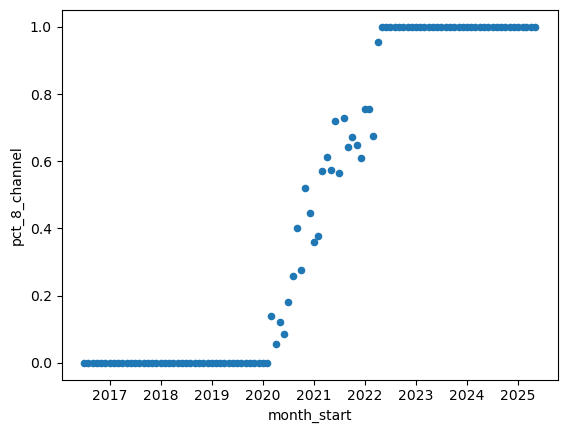

In [44]:
monthly_counts.loc[12487145].plot.scatter(y="pct_8_channel", x="month_start")

<Axes: xlabel='month_start', ylabel='sample_count'>

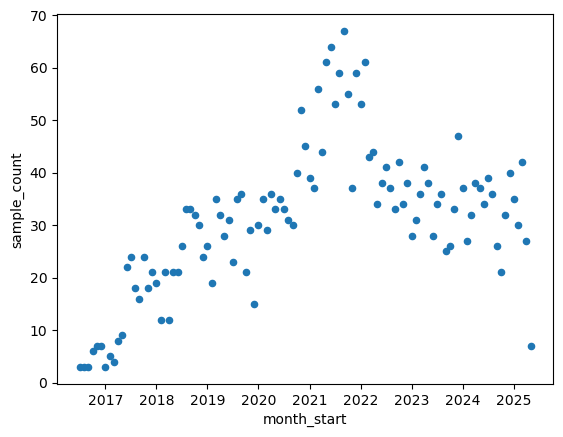

In [45]:
monthly_counts.loc[12487145].plot.scatter(y="sample_count", x="month_start")

In [48]:
first_month_8_channel = monthly_counts[monthly_counts.pct_8_channel > 0.5].reset_index().drop_duplicates(subset=["grid_id"]).set_index("grid_id")
first_month_8_channel

month_start  sample_count  count_8_channel  pct_8_channel
grid_id                                                           
12487113  2020-11-01            12              8.0       0.666667
12487114  2020-11-01            13              9.0       0.692308
12487115  2020-12-01            11              7.0       0.636364
12487116  2021-02-01            14             11.0       0.785714
12487117  2021-02-01            20             14.0       0.700000
...              ...           ...              ...            ...
13865108  2021-03-01            29             16.0       0.551724
13865109  2021-03-01            31             20.0       0.645161
13865110  2021-03-01            33             17.0       0.515152
13865111  2021-03-01            41             25.0       0.609756
13865112  2021-03-01            41             25.0       0.609756

[4048 rows x 4 columns]

/opt/homebrew/Caskroom/miniconda/base/envs/planet_coverage/lib/python3.11/site-packages/shapely/constructive.py:180: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/opt/homebrew/Caskroom/miniconda/base/envs/planet_coverage/lib/python3.11/site-packages/shapely/predicates.py:778: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/opt/homebrew/Caskroom/miniconda/base/envs/planet_coverage/lib/python3.11/site-packages/shapely/constructive.py:180: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/opt/homebrew/Caskroom/miniconda/base/envs/planet_coverage/lib/python3.11/site-packages/shapely/predicates.py:778: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


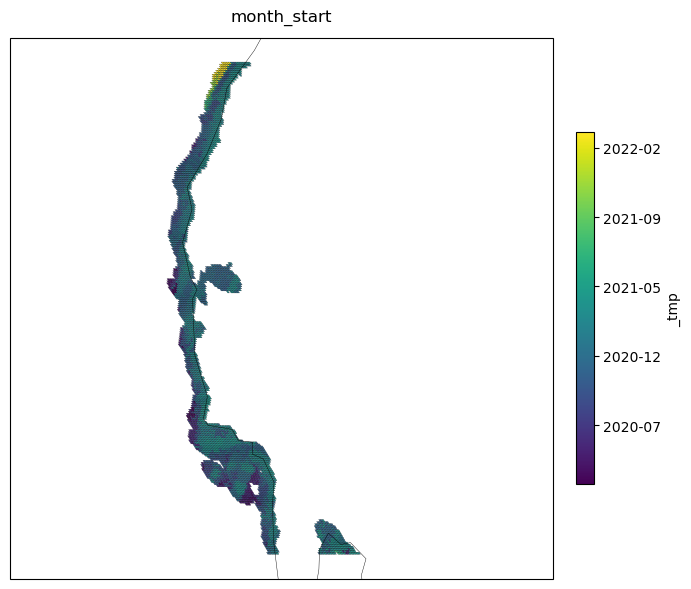

In [51]:
geo_tide = grids_ca.join(first_month_8_channel[["month_start"]], how="left").dropna(subset=['month_start'])
plot_gdf_column(geo_tide, "month_start", title="month_start", show_coastlines=True)

/opt/homebrew/Caskroom/miniconda/base/envs/planet_coverage/lib/python3.11/site-packages/shapely/constructive.py:180: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/opt/homebrew/Caskroom/miniconda/base/envs/planet_coverage/lib/python3.11/site-packages/shapely/predicates.py:778: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/opt/homebrew/Caskroom/miniconda/base/envs/planet_coverage/lib/python3.11/site-packages/shapely/constructive.py:180: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/opt/homebrew/Caskroom/miniconda/base/envs/planet_coverage/lib/python3.11/site-packages/shapely/predicates.py:778: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


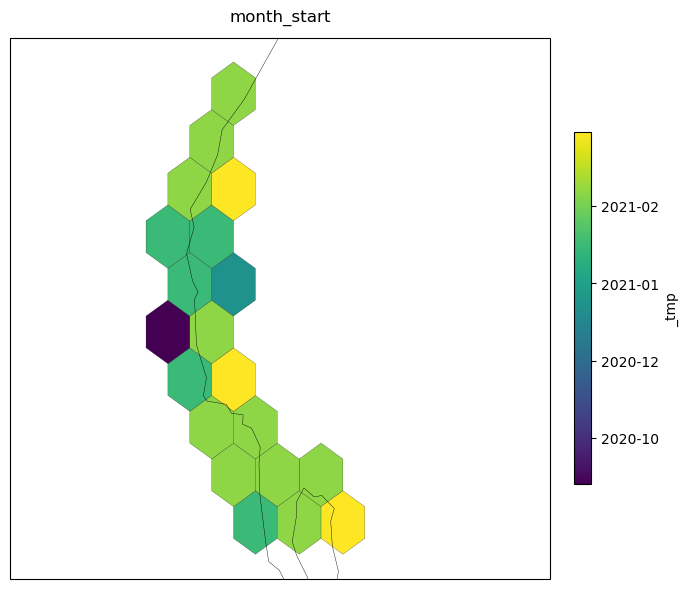

In [56]:
hex_counts = grids_ca[["hex_id"]].join(monthly_counts, how='left')

agg = (
    hex_counts.groupby(['hex_id', 'month_start'], as_index=False, sort=False)[['count_8_channel', 'sample_count']]
      .sum()                                # ← sums within each hex
      .assign(
          pct_8_channel=lambda d: d['count_8_channel'] / d['sample_count']  # or * 100 for %
      )
)

agg = agg[agg.index >= 0]
agg = agg[agg.pct_8_channel > 0.5].reset_index().drop_duplicates(subset=["hex_id"]).set_index("hex_id")
agg = agg.join(hex_grid_ca[["geometry"]])
gdf = gpd.GeoDataFrame(agg, geometry="geometry")

plot_gdf_column(gdf, "month_start", title="month_start", show_coastlines=True)

In [42]:
image_paths = sorted(list(Path("/Users/kyledorman/data/planet_coverage/figs/points_30km/time_between/").glob("median_*all*")))
image_paths

[PosixPath('/Users/kyledorman/data/planet_coverage/figs/points_30km/time_between/median_p95_time_between_samples_all_2016.png'),
 PosixPath('/Users/kyledorman/data/planet_coverage/figs/points_30km/time_between/median_p95_time_between_samples_all_2017.png'),
 PosixPath('/Users/kyledorman/data/planet_coverage/figs/points_30km/time_between/median_p95_time_between_samples_all_2018.png'),
 PosixPath('/Users/kyledorman/data/planet_coverage/figs/points_30km/time_between/median_p95_time_between_samples_all_2019.png'),
 PosixPath('/Users/kyledorman/data/planet_coverage/figs/points_30km/time_between/median_p95_time_between_samples_all_2020.png'),
 PosixPath('/Users/kyledorman/data/planet_coverage/figs/points_30km/time_between/median_p95_time_between_samples_all_2021.png'),
 PosixPath('/Users/kyledorman/data/planet_coverage/figs/points_30km/time_between/median_p95_time_between_samples_all_2022.png'),
 PosixPath('/Users/kyledorman/data/planet_coverage/figs/points_30km/time_between/median_p95_time_

In [43]:
from PIL import Image


def make_gif(frame_folder):
    frames = [Image.open(image) for image in image_paths[:-1]]
    frame_one = frames[0]
    frame_one.save("/Users/kyledorman/Desktop/time_between.gif", format="GIF", append_images=frames,
               save_all=True, duration=500, loop=0)
    
make_gif(None)
